# Basic Analysis ECG Data
* Download data from here: https://www.physionet.org/content/ecg-arrhythmia/1.0.0/
* if working with PyCharm, data folder should probably be marked as "Excluded", else indexing will take forever

ToDo:
* maybe also use age and gender information?

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import utilities.data_loader as data_loader
import utilities.filter_data as filter_data
import importlib
importlib.reload(data_loader)
importlib.reload(filter_data)

<module 'utilities.filter_data' from '/mnt/c/Users/phil/university/verona/visual-intelligence-ecg-project/utilities/filter_data.py'>

In [3]:
data_path = "data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/"
ecg_data_path = data_path + "WFDBRecords/"

* .mat file contains 12 channels of measurements
* .hea file contains information about the measurements at the top, followed by information about the patient
* patient information includes age, sex and DX
* DX is a comma separated list of diagnoses, encoded as numbers

In [4]:
sample_entry = data_loader.load_number_of_random_samples(ecg_data_path, 3)

Loaded 0 of 3


In [5]:
print(sample_entry[0]['data'].shape)
print(len(sample_entry[0]['labels']))
print(sample_entry[0]['binary_label'])
print(sample_entry[2]['binary_label'])

(5000, 12)
1
0
0


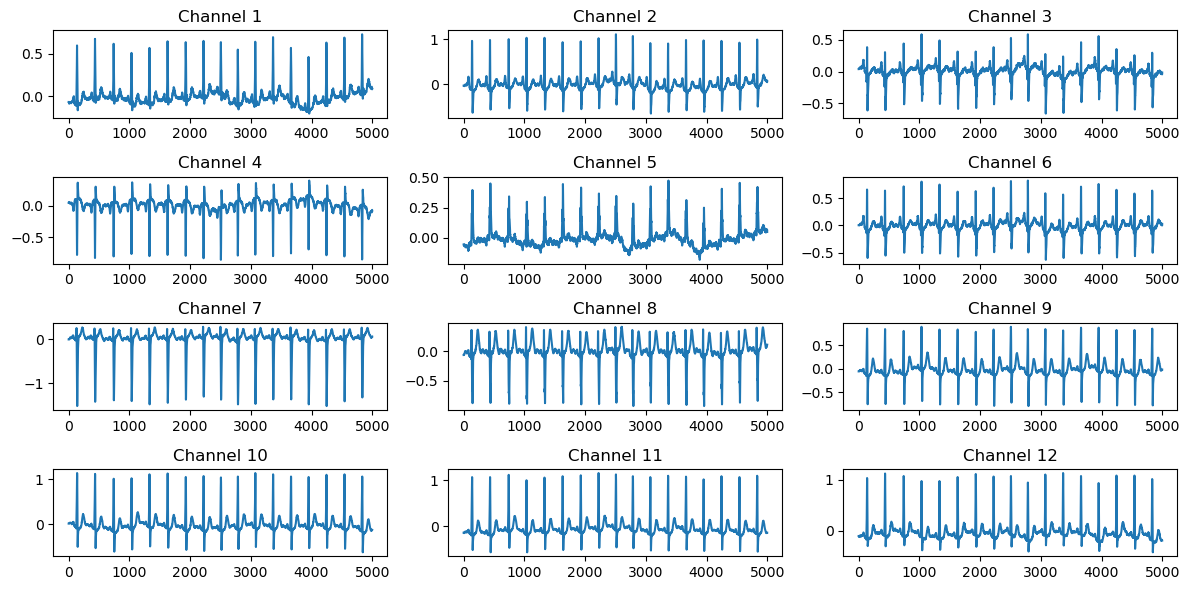

In [6]:
# healty sample
plt.figure(figsize=(12,6))
for index in range(sample_entry[2]['data'].shape[1]):
    plt.subplot(4, 3, index + 1)
    plt.plot(sample_entry[2]['data'][:, index])
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

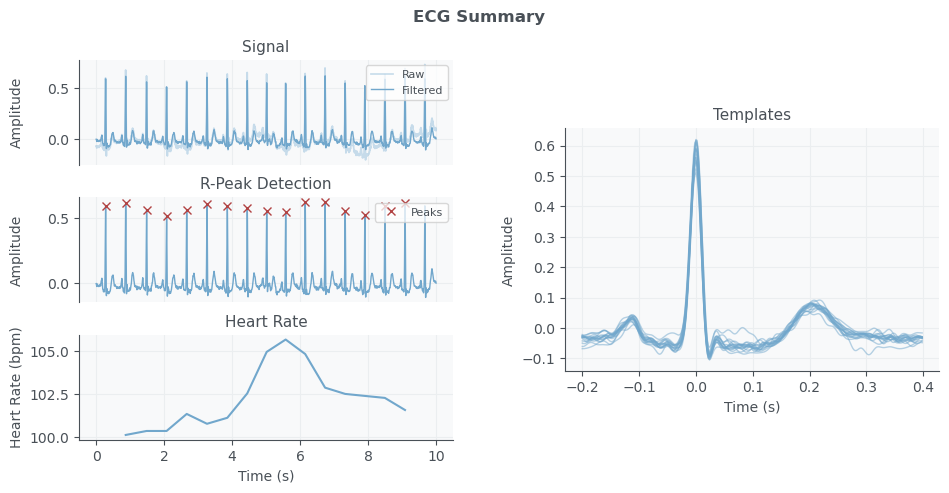

In [7]:
from biosppy.signals import ecg
out = ecg.ecg(signal=sample_entry[2]['data'][:, 0], sampling_rate=500, show=True)

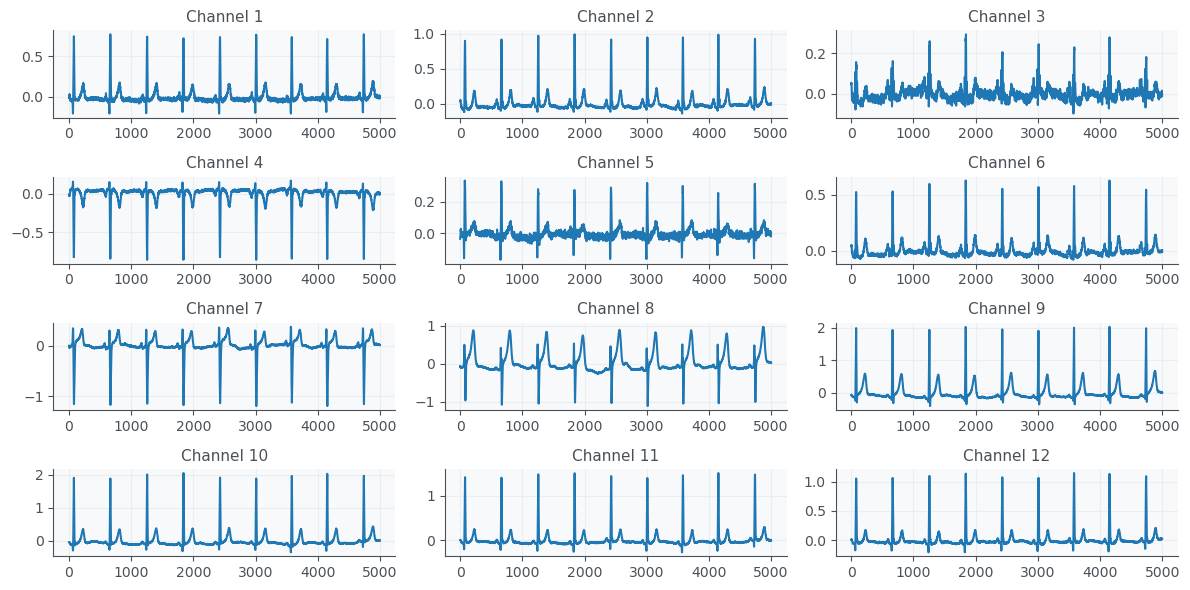

In [8]:
# unhealty sample
plt.figure(figsize=(12,6))
for index in range(sample_entry[0]['data'].shape[1]):
    plt.subplot(4, 3, index + 1)
    plt.plot(sample_entry[0]['data'][:, index])
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

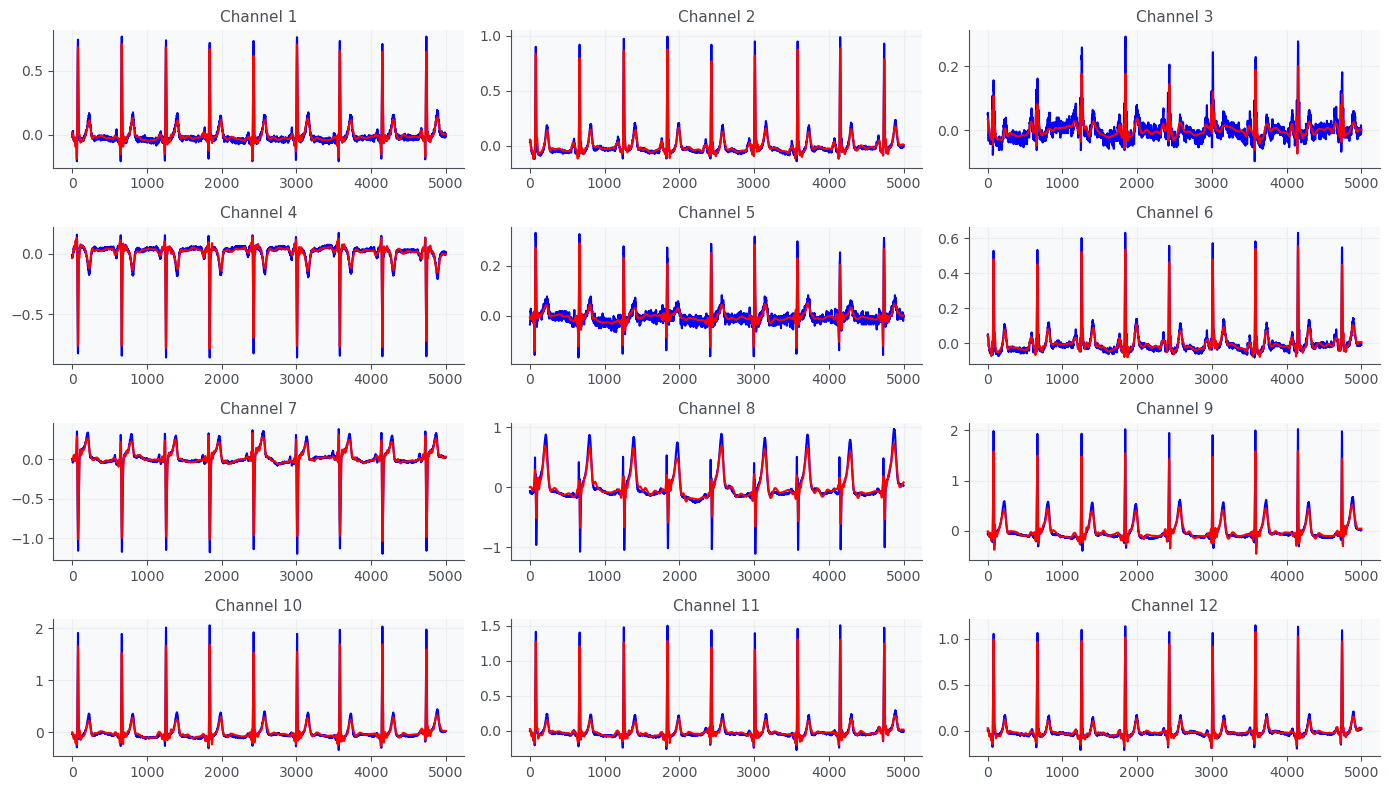

In [9]:
# example dwt filtering
importlib.reload(filter_data)
test_sample = sample_entry[0]['data']
plt.figure(figsize=(14,8))
filtered_signals = []
for index, signal in enumerate(test_sample.T):
    filtered_signal = filter_data.apply_dwt_to_eliminate_baseline_wander(signal, hard_threshold=False)
    filtered_signals.append(filtered_signal)
    plt.subplot(4, 3, index + 1)
    plt.plot(sample_entry[0]['data'][:, index], color='blue')
    plt.plot(filtered_signal, color='red')
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

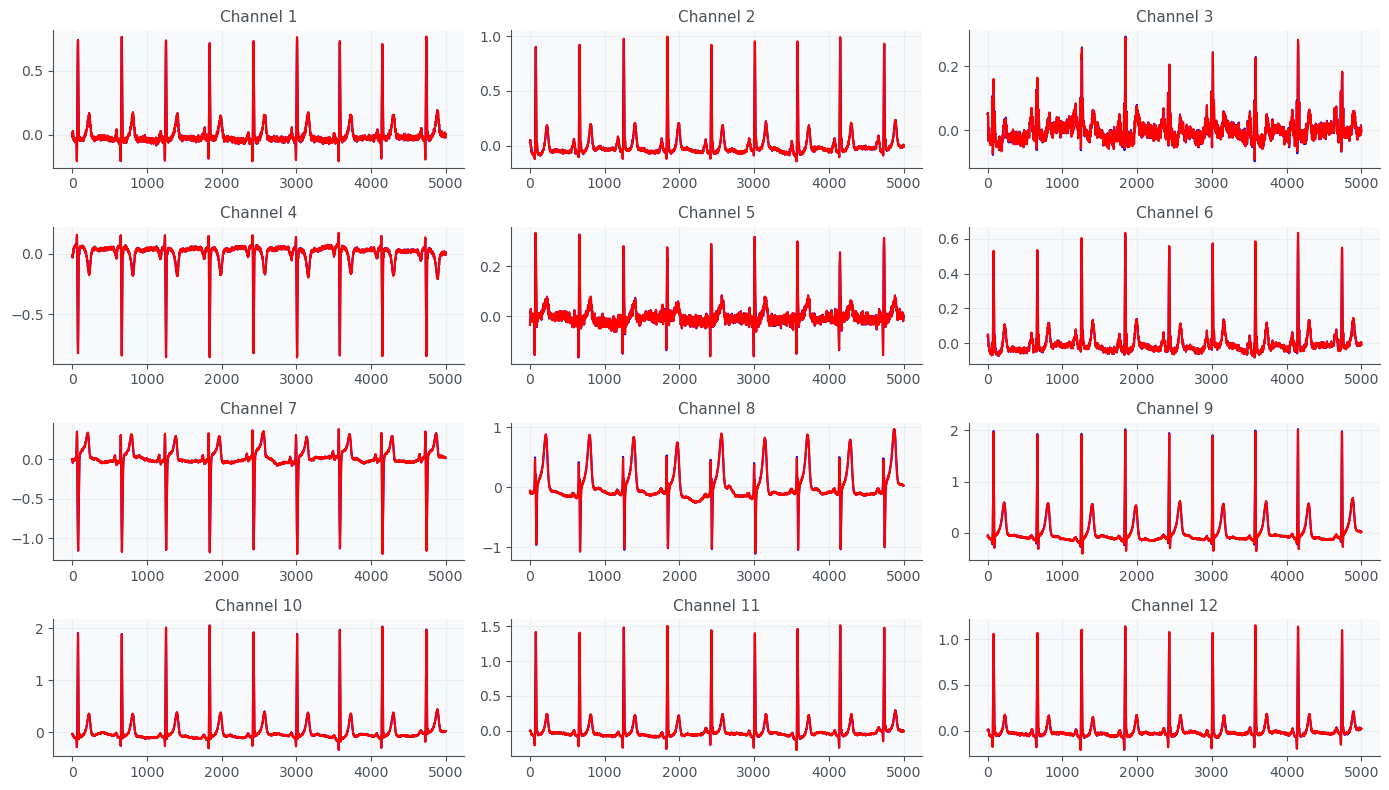

In [10]:
# example notch filtering for powerline noise filtering
importlib.reload(filter_data)
test_sample = sample_entry[0]['data']
plt.figure(figsize=(14,8))
filtered_signals = []
for index, signal in enumerate(test_sample.T):
    filtered_signal = filter_data.apply_notch_filter(signal)
    filtered_signals.append(filtered_signal)
    plt.subplot(4, 3, index + 1)
    plt.plot(sample_entry[0]['data'][:, index], color='blue')
    plt.plot(filtered_signal, color='red')
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()
    

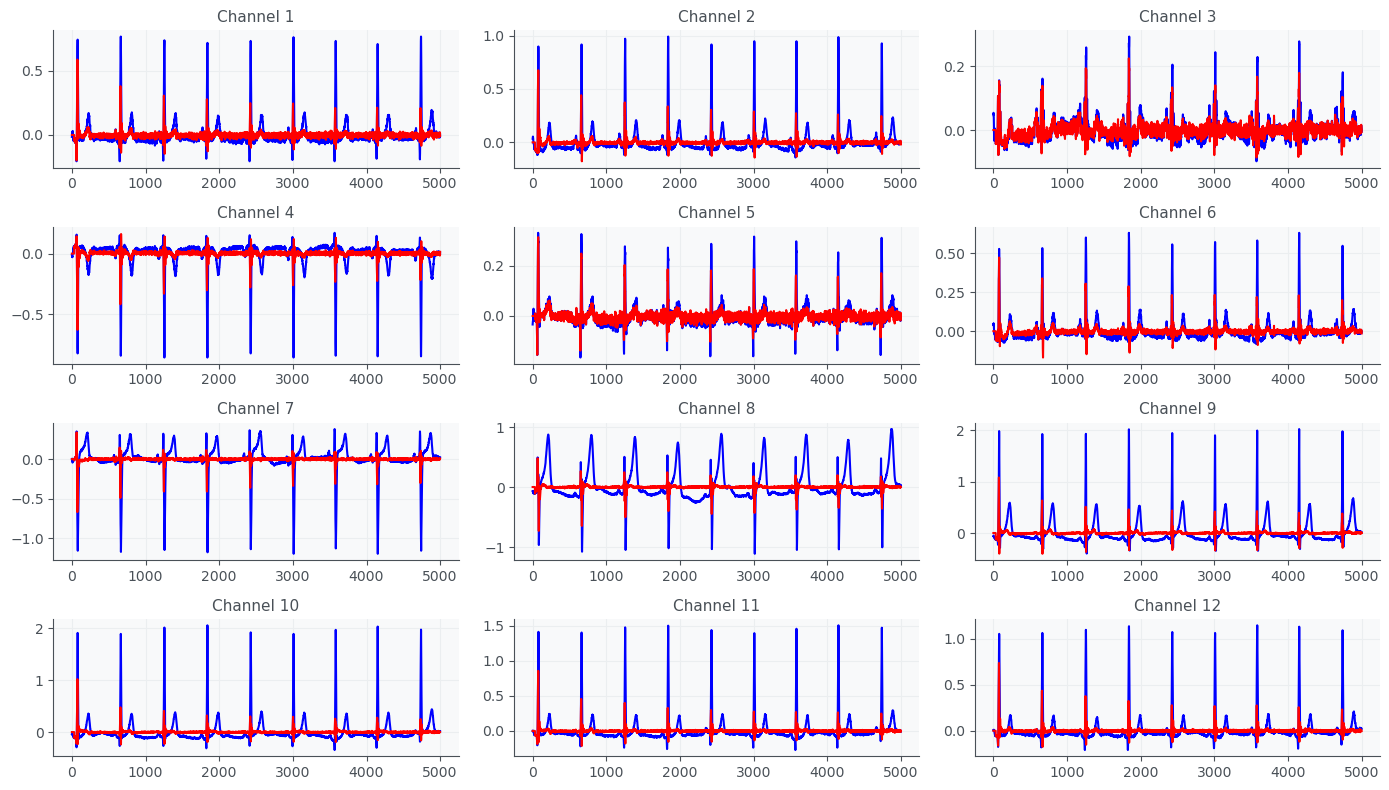

In [11]:
# example adaptive filtering
importlib.reload(filter_data)
test_sample = sample_entry[0]['data']
plt.figure(figsize=(14,8))
filtered_signals = []
for index, signal in enumerate(test_sample.T):
    filtered_signal = filter_data.apply_adaptive_filter(signal)
    filtered_signals.append(filtered_signal)
    plt.subplot(4, 3, index + 1)
    plt.plot(sample_entry[0]['data'][:, index], color='blue')
    plt.plot(filtered_signal, color='red')
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

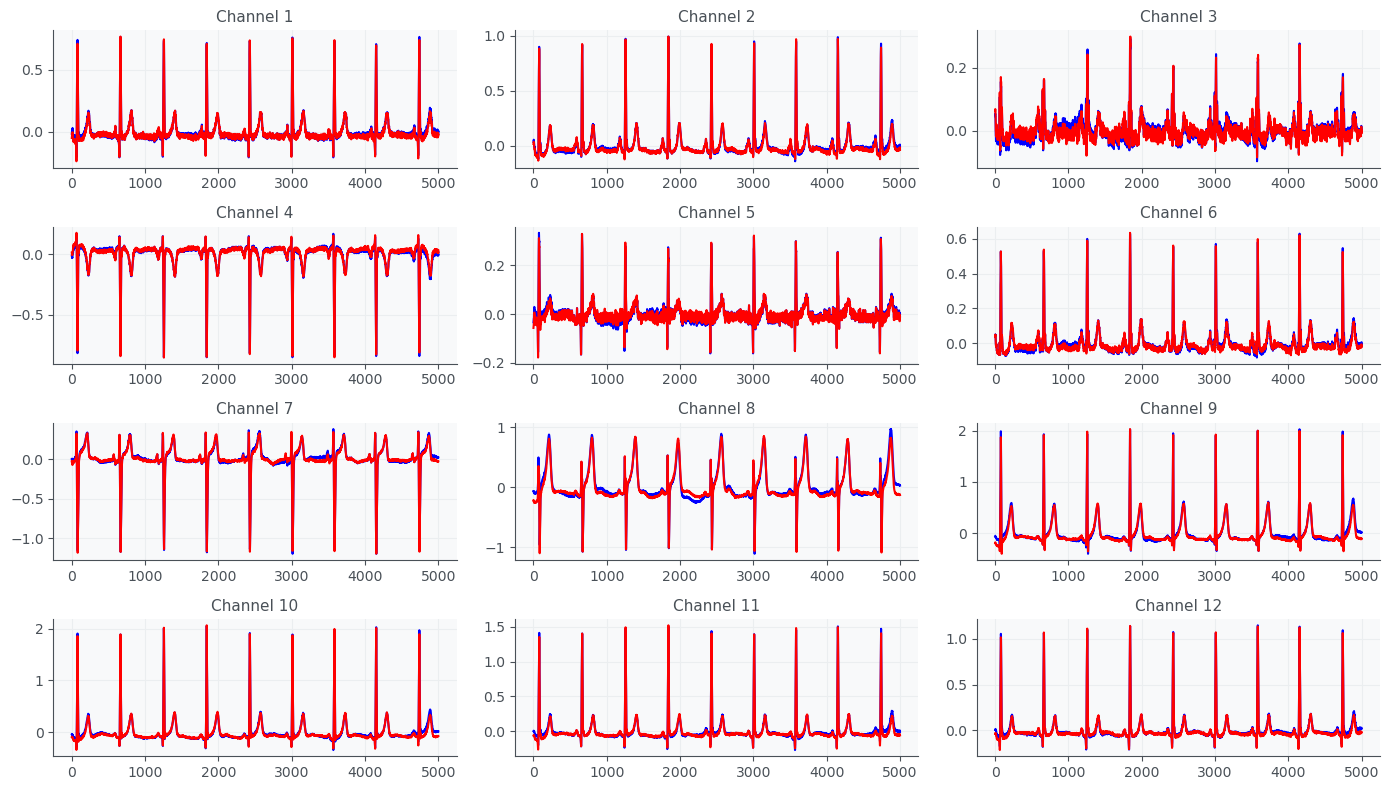

In [12]:
# example baseline removal fir
importlib.reload(filter_data)
test_sample = sample_entry[0]['data']
plt.figure(figsize=(14,8))
filtered_signals = []
for index, signal in enumerate(test_sample.T):
    filtered_signal = filter_data.fir_filter_to_eliminate_baseline_wander(signal)
    filtered_signals.append(filtered_signal)
    plt.subplot(4, 3, index + 1)
    plt.plot(sample_entry[0]['data'][:, index], color='blue')
    plt.plot(filtered_signal, color='red')
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

In [13]:
# load label names and identifiers
condition_names = pd.read_csv(data_path + "ConditionNames_SNOMED-CT.csv", header=0, names=['acronym', 'name', 'identifier'], delimiter=',')
condition_names['name'] = condition_names['name'].str.replace('\xa0', ' ')  # remove non-breaking spaces

In [14]:
importlib.reload(data_loader)
test = data_loader.get_count_all_labels(ecg_data_path, limit_samples=2000)

Processing 2000 of 45152
get_count_all_labels error count: 1


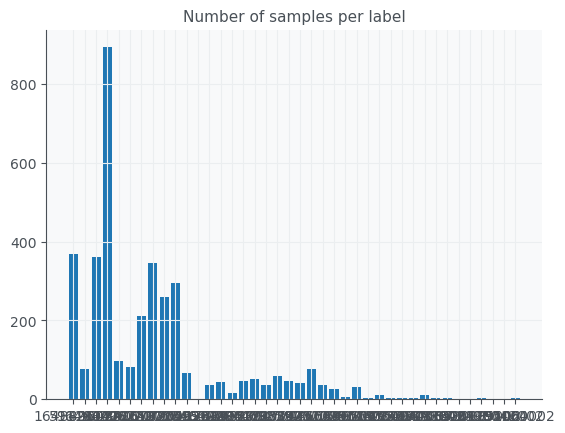

In [15]:
plt.title('Number of samples per label')
plt.bar(range(len(test)), list(test.values()), align='center')
plt.xticks(range(len(test)), list(test.keys()))
plt.show()

In [16]:
data = data_loader.load_number_of_random_samples(ecg_data_path, 100)

Loaded 100 of 100


In [17]:
healty_samples = [entry for entry in data if entry['binary_label'] == 0]
unhealty_samples = [entry for entry in data if entry['binary_label'] == 1]
print(f"Number of healty samples: {len(healty_samples)}")
print(f"Number of unhealty samples: {len(unhealty_samples)}")

Number of healty samples: 77
Number of unhealty samples: 23


In [18]:
X = np.array([entry['data'] for entry in data], dtype=np.float32)
y = np.array([entry['binary_label'] for entry in data], dtype=np.float32)
print(X.shape)
print(y.shape)

(100, 5000, 12)
(100,)


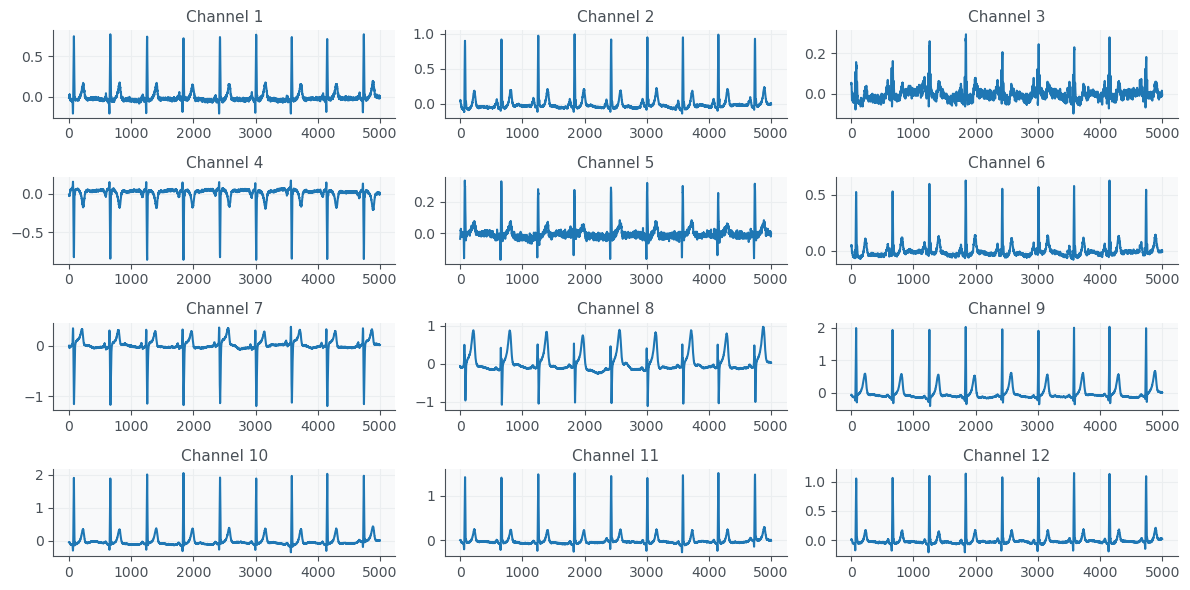

In [19]:
# data pre-filtering
sample_index = 0
plt.figure(figsize=(12,6))
for index in range(X.shape[2]):
    plt.subplot(4, 3, index + 1)
    plt.plot(X[sample_index, :, index])
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

# Filter Data
* apply low_pass_filter, loess_filter, ...

In [20]:
importlib.reload(filter_data)
X_filtered = np.zeros(X.shape, dtype=np.float32)
cutoff_frequency = 150  # TODO: find good value

for index in range(X.shape[0]):
    if index % 50 == 0 or index == X_filtered.shape[0] - 1:
        clear_output(wait=True)
        print(f"Filtering sample {index + 1}/{X_filtered.shape[0]}")
    for channel in range(X.shape[2]):
        X_filtered[index, :, channel] = filter_data.apply_low_pass_filter(X[index, :, channel], cutoff_frequency)

Filtering sample 100/100


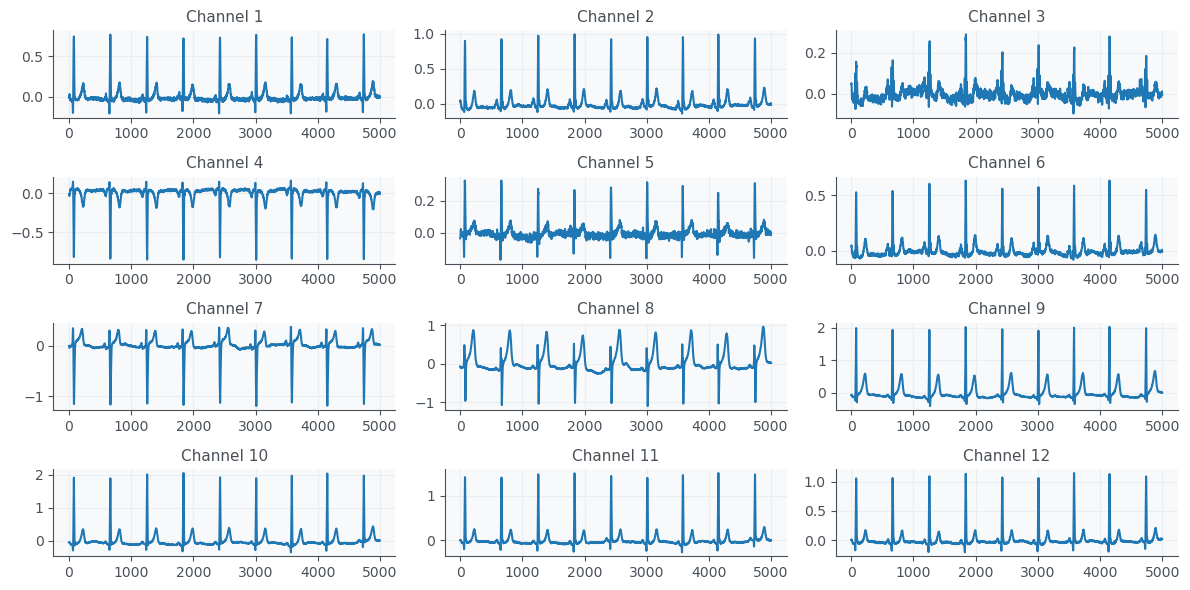

In [21]:
# sample after low pass
plt.figure(figsize=(12,6))
for index in range(X_filtered.shape[2]):
    plt.subplot(4, 3, index + 1)
    plt.plot(X_filtered[sample_index, :, index])
    plt.title(f"Channel {index + 1}")
    plt.tight_layout()
plt.show()

In [22]:
# NOTE: SUPER slow...
# importlib.reload(filter_data)
# for index in range(X_filtered.shape[0]):
#     if index % 1 == 0 or index == X_filtered.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Filtering sample {index + 1}/{X_filtered.shape[0]}")
#     for channel in range(X_filtered.shape[2]):
#         X_filtered[index, :, channel] = filter_data.apply_loess_filter(X_filtered[index, :, channel])
#         
# # sample after loess filtering
# plt.figure(figsize=(12,6))
# for index in range(X_filtered.shape[2]):
#     plt.subplot(4, 3, index + 1)
#     plt.plot(X_filtered[sample_index, :, index])
#     plt.title(f"Channel {index + 1}")
#     plt.tight_layout()
# plt.show()

In [23]:
# TODO: sample uses non-local means filter, but could only find an implementation for images...
# Note: or here is a pytorch implementation: https://github.com/magland/ephys_nlm

# Feature Extraction
* todo...

# Data into dataset

In [24]:
from sklearn.model_selection import train_test_split
from utilities.utils import CustomDataset
from torch.utils.data import DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80, 5000, 12)
(20, 5000, 12)
(80,)
(20,)


# Model
* ScatNet -> Kymatio stuff
* apply scattering etc. followed by CNN, like done during Lab

Possible examples:
* https://www.kymat.io/gallery_2d/mnist_keras.html#sphx-glr-gallery-2d-mnist-keras-py
* nice one: Scattering2D CNN: https://www.kymat.io/gallery_2d/cifar_torch.html#sphx-glr-gallery-2d-cifar-torch-py

In [28]:
import torch

# Wavelet filters
* https://www.kymat.io/gallery_1d/plot_filters.html#sphx-glr-gallery-1d-plot-filters-py

In [29]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory

In [30]:
T = 2**13 # The filters are defined for a certain support size T which corresponds to the size of the input signal. The only restriction is that T must be a power of two
J = 5 #  specifies the maximum scale of the low-pass filters as a power of two. In other words, the largest filter will be concentrated in a time interval of size 2**J.
Q = (8, 1) # Q parameter controls the number of wavelets per octave in the first-and second-order filter banks. The larger the value, the narrower these filters in the frequency domain and the wider they are in the time domain (in general, the number of non-negligible oscillations in time is proportional to Q). For audio signals, it is often beneficial to have a large value for Q1 (between 4 and 16), since these signals are often highly oscillatory and are better localized in frequency than they are in time. For the second layer, Q2 is typically equal to 1 or 2. In this example, we set Q1=8 and Q2=1

In [31]:
phi_f, psi1_f, psi2_f = scattering_filter_factory(T, J, Q, T)  # create the filters
# The phi_f output is a dictionary where each integer key corresponds points to the instantiation of the filter at a certain resolution. Specifically, phi_f[‘levels’][0] corresponds to the lowpass filter at resolution T, while phi_f[‘levels’][1] corresponds to the filter at resolution T/2, and so on
#

# Scattering 1D on each channel

In [32]:
from kymatio.torch import Scattering1D

In [33]:
# sample
sample = X_train[:1]
single_ecg_measurement = sample[0][:, 0]
single_ecg_measurement_norm = torch.from_numpy(single_ecg_measurement / np.max(np.abs(single_ecg_measurement)))

In [44]:
# J = 6  # averaging scale is specified as a power of two. set J = 6 to get an averaging, or maximum, scattering scale of 2**6 = 64 samples
# Q = 16  # set the number of wavelets per octave. This lets us resolve frequencies at a resolution of 1/16 octaves.
# scattering = Scattering1D(J, len(single_ecg_measurement_norm), Q)

J = 8  # number of scales
Q = 8  # number of wavelets per octave
log_eps = 1e-6
scattering = Scattering1D(J, shape=len(single_ecg_measurement_norm), Q=Q)

In [45]:
Sx = scattering(single_ecg_measurement_norm)

In [63]:
Sx[1]

tensor([0.0016, 0.0016, 0.0015, 0.0014, 0.0014, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016,
        0.0016])

In [60]:
torch.log(torch.abs(Sx) + log_eps).shape

torch.Size([234, 19])

In [54]:
scattering.meta()['order']

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [48]:
meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

In [66]:
Sx[order1].shape

torch.Size([54, 19])

In [65]:
Sx[order1][10]

tensor([0.0013, 0.0013, 0.0013, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0013, 0.0014, 0.0016, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016,
        0.0016])

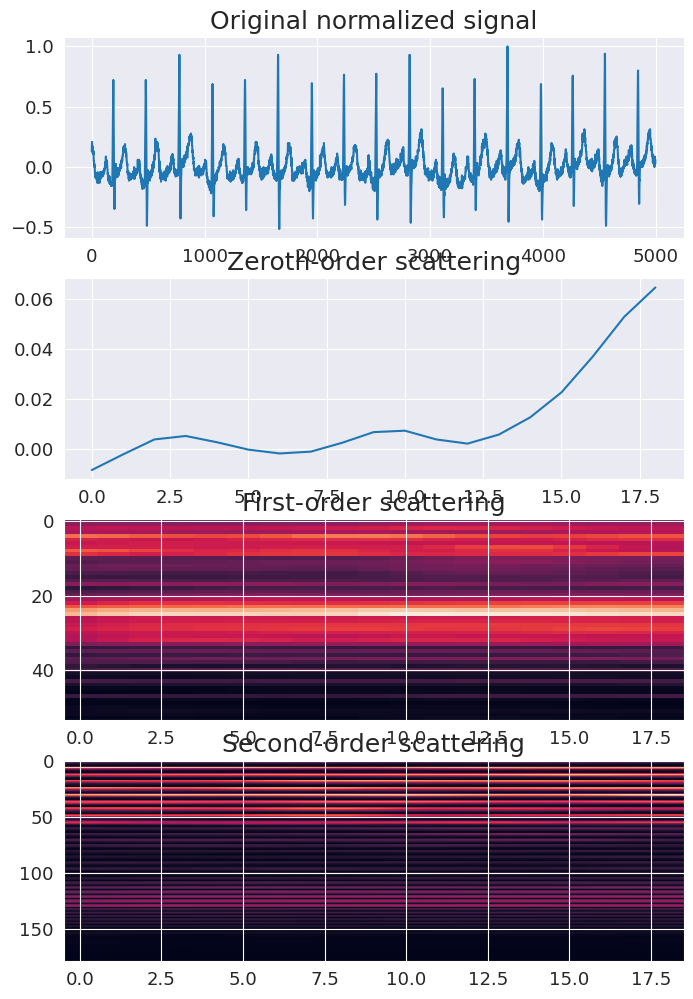

In [49]:
plt.figure(figsize=(8, 12))
plt.subplot(4, 1, 1)
plt.plot(single_ecg_measurement_norm)
plt.title('Original normalized signal')

plt.subplot(4, 1, 2)
plt.plot(Sx[order0][0])
plt.title('Zeroth-order scattering')  # simply an average of the original signal at the scale 2**J.

plt.subplot(4, 1, 3)
plt.imshow(Sx[order1], aspect='auto')
plt.title('First-order scattering')

plt.subplot(4, 1, 4)
plt.imshow(Sx[order2], aspect='auto')
plt.title('Second-order scattering')

plt.show()

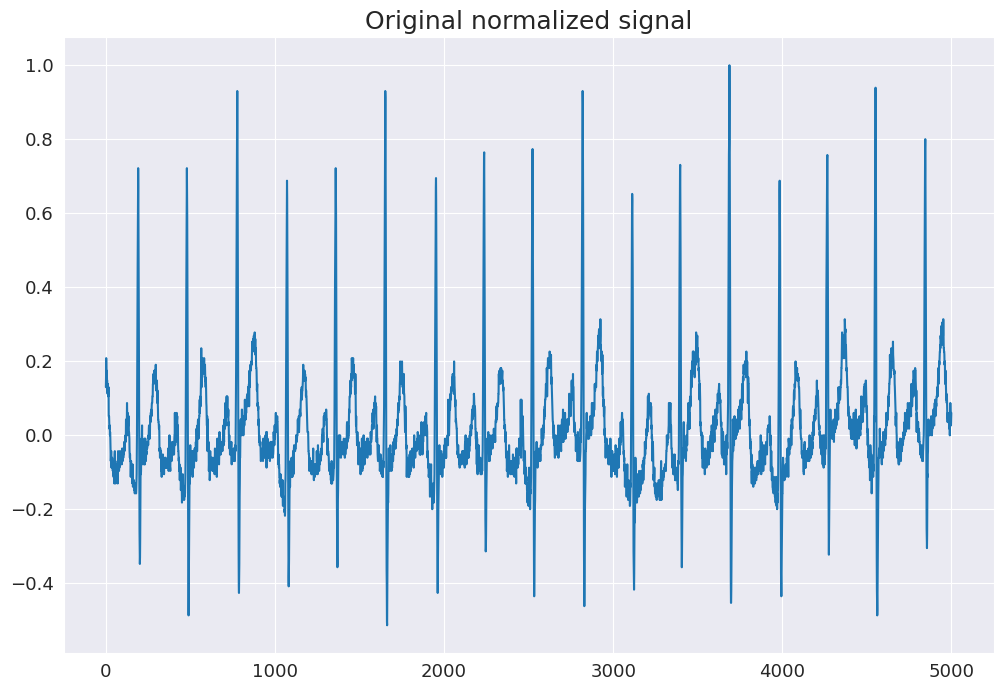

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(single_ecg_measurement_norm)
plt.title('Original normalized signal')
plt.show()

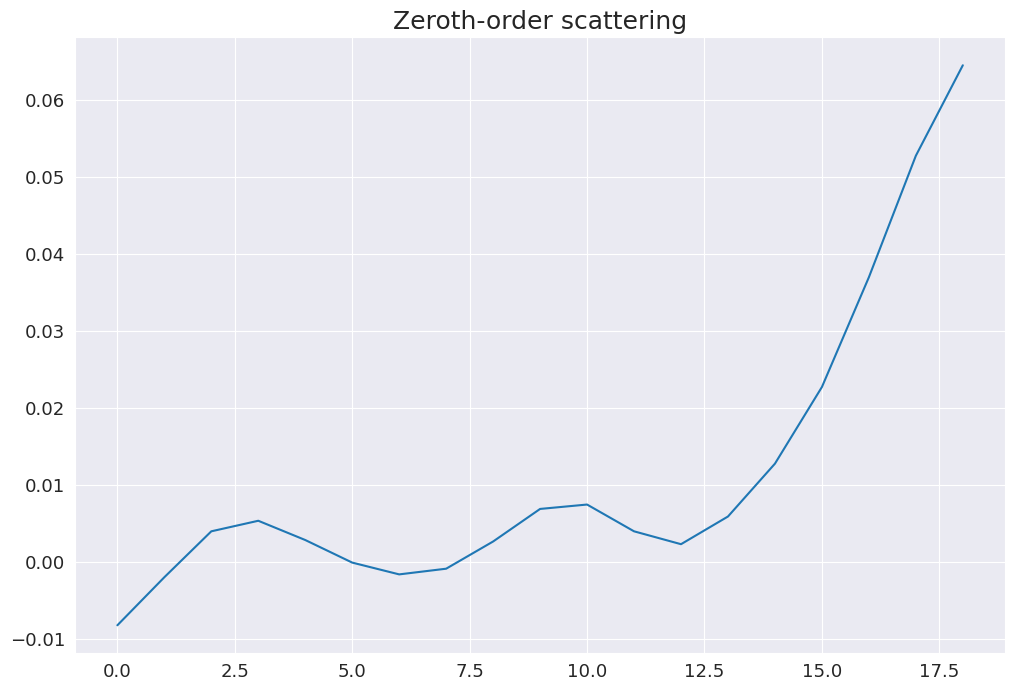

In [51]:

plt.figure(figsize=(12, 8))
plt.plot(Sx[order0][0])
plt.title('Zeroth-order scattering')  # simply an average of the original signal at the scale 2**J.
plt.show()

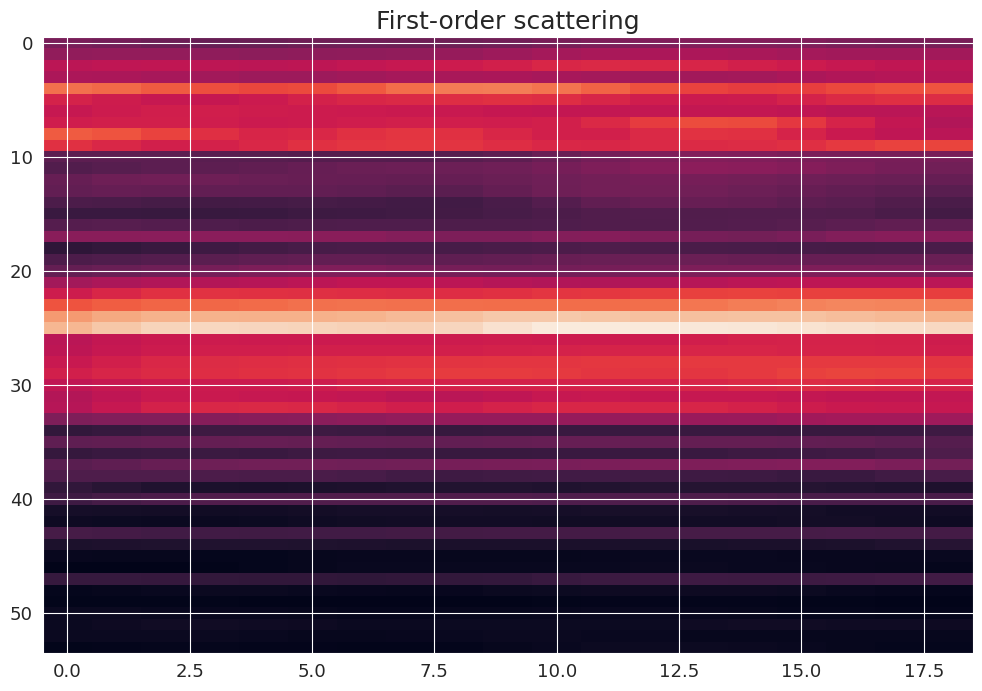

In [52]:

plt.figure(figsize=(12, 8))
plt.imshow(Sx[order1], aspect='auto')
plt.title('First-order scattering')
plt.show()

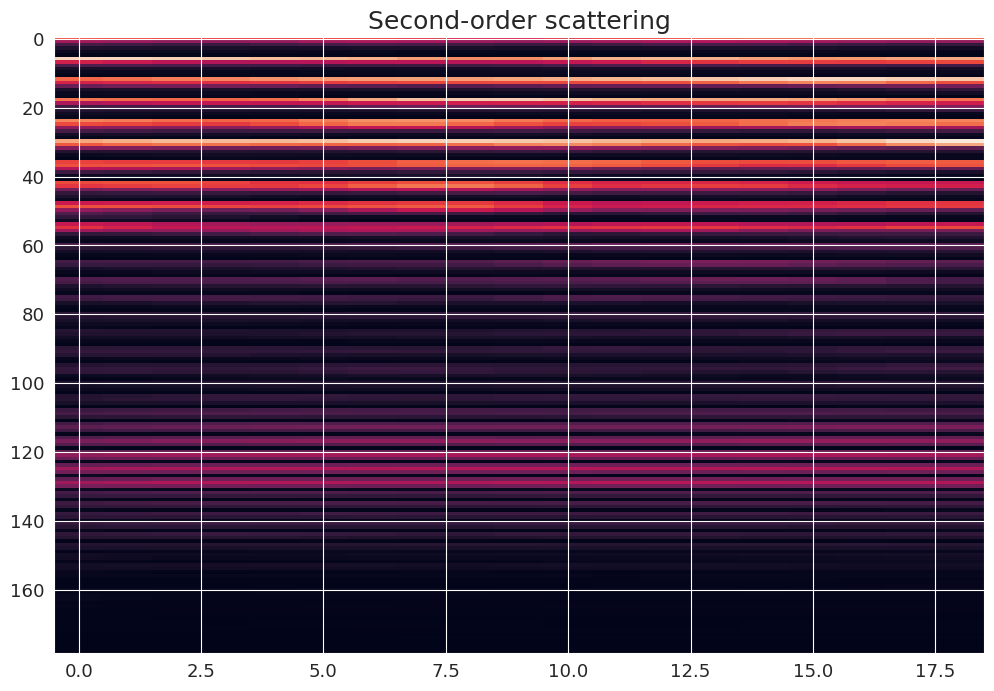

In [53]:

plt.figure(figsize=(12, 8))
plt.imshow(Sx[order2], aspect='auto')
plt.title('Second-order scattering')
plt.show()

## Implement filtering as next step

## Possible models discussion
* Scatnet followed by some classifier, maybe first SVM, then later change to multilayer perceptron FF
* change NN to CNN
* LSTM
* beginning Scatnet and SVM!